In [1]:
import os, datetime
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from util import chissl_mongo as cm
%load_ext autoreload
%autoreload 2

In [2]:
VAST_PATH = '/Users/aren438/data/VAST Challenge 2014/VASTChal2014MC2-20140430'
EXTRAS_PATH = '/Users/aren438/data/VAST Challenge 2014/extras'

In [3]:
gps_df = pd.read_csv(os.path.join(VAST_PATH, 'gps.csv'),
                     parse_dates=[0],
                     date_parser=lambda s: datetime.datetime.strptime(s, '%m/%d/%Y %H:%M:%S'))\
    .set_index('Timestamp')\
    .sort_index()
    
gps_df.head()

,id,lat,long
Timestamp,,,
2014-01-06 06:28:01,35,36.076225,24.874689
2014-01-06 06:28:01,35,36.076220,24.874596
2014-01-06 06:28:03,35,36.076211,24.874443
2014-01-06 06:28:05,35,36.076217,24.874253
2014-01-06 06:28:06,35,36.076214,24.874167


# Resample
to 1-minute time chunks and fill in missing times

In [54]:
gps_df_expanded = gps_df.groupby('id', group_keys=False, as_index=False)\
    .resample('T')\
    .apply(lambda x: x.iloc[-1] if len(x) else None)\
    .ffill()\
    [['id', 'long', 'lat']]
    
gps_df_expanded['id'] = gps_df_expanded['id'].astype('int')
    
gps_df_expanded.head()

,id,long,lat
Timestamp,,,
2014-01-06 07:20:00,1,24.884676,36.065583
2014-01-06 07:21:00,1,24.885896,36.063849
2014-01-06 07:22:00,1,24.885866,36.063658
2014-01-06 07:23:00,1,24.885866,36.063658
2014-01-06 07:24:00,1,24.885866,36.063658


# Location Metadata

In [55]:
from sklearn.neighbors import KDTree

named_places_df = pd.read_csv(os.path.join(EXTRAS_PATH,
                                           'NamedPlacesWithCategories.csv'))

named_places_df.head()

,name,lat,long,canonical,category
0,Industrial Supplies Consolidated,36.046021,24.901365,True,Shopping
1,GAStech-Kronos,36.048021,24.879565,True,GASTech
2,Kronos International Airport,36.050920,24.825863,True,Public
3,Ouzeri Elian,36.051920,24.870764,True,Dining
4,Shoppers' Delight,36.052820,24.868564,True,Shopping


In [56]:
dist, nei = KDTree(named_places_df[['long', 'lat']], metric='euclidean')\
    .query(gps_df_expanded[['long', 'lat']])

gps_df_expanded['location_distance'] = dist
gps_df_expanded['location_index'] = nei.flatten()

gps_df_expanded.head()

,id,long,lat,location_distance,location_index
Timestamp,,,,,
2014-01-06 07:20:00,1,24.884676,36.065583,0.002023,53
2014-01-06 07:21:00,1,24.885896,36.063849,0.000230,46
2014-01-06 07:22:00,1,24.885866,36.063658,0.000037,46
2014-01-06 07:23:00,1,24.885866,36.063658,0.000037,46
2014-01-06 07:24:00,1,24.885866,36.063658,0.000037,46


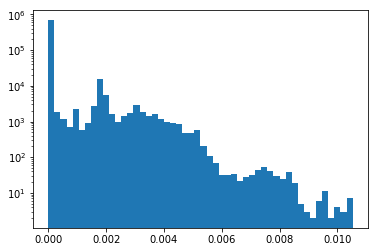

In [57]:
plt.hist(gps_df_expanded.location_distance, log=True, bins=50);
# use 0.001 as threshold

In [58]:
gps_df_expanded_with_locations = pd.merge(
    gps_df_expanded,
    named_places_df,
    left_on='location_index',
    right_index=True,
    suffixes=('', '_y')
).drop(['lat_y', 'long_y', 'canonical'], axis=1)

gps_df_expanded_with_locations.head()

,id,long,lat,location_distance,location_index,name,category
Timestamp,,,,,,,
2014-01-06 07:20:00,1,24.884676,36.065583,0.002023,53,Nils Calixto home,Home
2014-01-07 07:20:00,1,24.884629,36.065572,0.002060,53,Nils Calixto home,Home
2014-01-08 07:47:00,1,24.884639,36.065581,0.002046,53,Nils Calixto home,Home
2014-01-09 07:21:00,1,24.884625,36.065599,0.002040,53,Nils Calixto home,Home
2014-01-10 07:50:00,1,24.884694,36.065615,0.001987,53,Nils Calixto home,Home


In [59]:
cars_df = pd.read_csv(os.path.join(VAST_PATH, 'car-assignments.csv'))\
    .dropna(axis=0)
    
cars_df['CarID'] = cars_df.CarID.astype(int)

cars_df['FullName'] = cars_df.LastName.str.cat(cars_df.FirstName, sep=', ')
full_names_dict = dict(cars_df[['CarID', 'FullName']].values)

truck_drivers = pd.DataFrame([{'CarID': i,
  'LastName': 'Driver',
  'FirstName': 'Truck',
  'FullName': 'Truck Driver',
  'CurrentEmploymentType': 'Facilities',
  'CurrentEmploymentTitle': 'Truck Driver'
 }
 for i in [101, 104, 105, 106, 107]])

cars_df = pd.concat((cars_df, truck_drivers)).set_index('CarID')
cars_df

,CurrentEmploymentTitle,CurrentEmploymentType,FirstName,FullName,LastName
CarID,,,,,
1,IT Helpdesk,Information Technology,Lucas,"Alcazar, Lucas",Alcazar
2,Engineer,Engineering,Lars,"Azada, Lars",Azada
3,Engineer,Engineering,Felix,"Balas, Felix",Balas
4,SVP/CFO,Executive,Ingrid,"Barranco, Ingrid",Barranco
5,IT Technician,Information Technology,Isak,"Baza, Isak",Baza
6,IT Group Manager,Information Technology,Linnea,"Bergen, Linnea",Bergen
7,Drill Technician,Engineering,Isande,"Borrasca, Isande",Borrasca
8,IT Technician,Information Technology,Nils,"Calixto, Nils",Calixto
9,Drill Technician,Engineering,Axel,"Calzas, Axel",Calzas


In [132]:
def get_person_day(x):    
    vehicle, date = x.name
    date_str = date.strftime('%Y-%m-%d')
    _id = f'{vehicle}-{date_str}'

    doc = cars_df.loc[vehicle].to_dict()
    doc['_id'] = _id
    x['hour'] = x.index.hour//2
    doc['data'] = x.to_dict(orient='records')
    
    return doc

docs = gps_df_expanded_with_locations.groupby([
    'id',
    pd.Grouper(freq='d'),
]).apply(get_person_day).values.tolist()

In [133]:
yDomain = sorted(named_places_df.category.unique())
xDomain = list(range(12))

In [134]:
from util import chissl_mongo as cm
chissl = cm.ChisslMongo(verbose=True)

chissl.create_collection('VAST 2014 MC2', docs, drop=True)

chissl.create_application('VAST Movement Analysis',
                          'VAST 2014 MC2',
                          'VastHistogramComponent',
                          'util.applications.vast.pipeline',
                          props={'x': 'hour',
                                 'xDomain': xDomain,
                                 'y': 'category',
                                 'yDomain': yDomain},
                          params={'nmf__n_components': 24},
                          drop=True)

{'_id': 'VAST Movement Analysis',
 'collection': 'VAST 2014 MC2',
 'component': 'VastHistogramComponent',
 'params': {'nmf__n_components': 24},
 'pipeline': 'util.applications.vast.pipeline',
 'props': {'x': 'hour',
  'xDomain': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
  'y': 'category',
  'yDomain': ['Apartment',
   'Coffee',
   'Dining',
   'GASTech',
   'Gas',
   'Home',
   'Industrial',
   'Lodging',
   'Public',
   'Recreation',
   'Shopping']}}